# **Amazon Music Reviews**

The goal of project is to go through a dataset of music reviews from Amazon music in order to build predictive models and generate useful business insights and strategy.


#### **Important preliminary steps before running the notebook:**
- Please make sure to install below libraries (in the first cell) if not already installed
- Please ensure the run time on google colab is set as GPU (deep learning model is used in this notebook)
- Please make sure the following four files are in your same directory as the notebook: 
1. train.csv
2. test.csv
3. glove.6B.100d.txt
4. rating_pairs.csv


In [ ]:
!pip install xgboost
!pip install nltk
!pip install wordcloud
!pip install bs4
!pip install surprise
!pip install contractions

### **Importing necessay libraries**

In [ ]:
import collections
import time
import pandas as pd
import numpy as np
import re
import joblib
import html
import string
import pickle
import unicodedata
import scipy.sparse
from bs4 import BeautifulSoup
from statistics import mean
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
nltk.download('wordnet')
from gensim.models import word2vec
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
import warnings
from textblob import TextBlob
plt.style.use('ggplot')
warnings.filterwarnings("ignore")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Reading the input files**

In [ ]:
DF_train = pd.read_csv('train.csv')
DF_test = pd.read_csv('test.csv')

General view of the input files

In [ ]:
DF_test.head()

,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,"02 11, 2017",u04140621,ok,Five Stars,1486771200,Pop,$31.20,p65721979,98944233,NaN
1,"01 29, 2018",u74766187,The 1955 and 1958 sets alone are worth the pur...,Buy It For the 1955 Set With Monk!,1517184000,Jazz,$34.04,p87809670,33903910,NaN
2,"08 29, 2005",u31689638,Mary J Blige is someone most people know of. S...,Mary's excellent debut! Classic!,1125273600,Pop,$1.72,p52702240,35386470,NaN
3,"11 2, 2015",u35613516,Very good satch album,Four Stars,1446422400,Pop,$10.99,p01314374,12404766,NaN
4,"01 3, 2012",u93320378,Well there are hundreds of Christmas anthologi...,CD lives up to its name,1325548800,Alternative Rock,$7.98,p84396269,68253688,NaN


In [ ]:
DF_train.head()

,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,5.0,"08 26, 2014",u92990698,A contemporary jazz and soul performer who's m...,""" CLASSIQUE """,1409011200,Jazz,$8.40,p23649501,3856620,NaN
1,5.0,"05 11, 2003",u36200649,Very good idea to put both the 'pop' and 'orch...,Exceeded my Expectations - This album RAWKS!,1052611200,Alternative Rock,$10.98,p58458313,56086781,NaN
2,5.0,"12 5, 2017",u10721702,This is a great collection of Carole King's so...,A Must-have for Carole King Fans,1512432000,Pop,$5.99,p97027626,55852154,NaN
3,5.0,"09 24, 2013",u86003775,The is album is a brilliant piece of Jazz fusi...,A Master piece!,1379980800,Jazz,$14.64,p43167086,43228100,NaN
4,5.0,"01 14, 2015",u25672859,Waited a LONG time for this DVD to be released...,especially if you like concert videos,1421193600,Alternative Rock,$9.92,p94494236,54425467,NaN


# **1 Data cleaning** 

## **1.1 Finding the missing data and implementing an appropriate strategy on them along with creating buckets for review times and item prices**
In this section, the missing data is found and an appropriate startegy is employed to either remove them or fill them with appropriate value(s). It should be noted that some data in the "price" is missing too, but it is not denoted by null values. This missing data is denoted by words without any meaning. This step will also take care of these missing prices.

Additionally, the item prices and review times are separated into different buckets for the simplification of the model features in the next steps.

### **1.1.1 The missing data in the training set**


#### **1.1.1.1 The null values in the training set**

In [ ]:
# Finding the columns with missing data in the training set
for colname in DF_train.columns:
    nullnum=len(DF_train[DF_train[colname].isnull()])
    # Finding other columns that contain null(s).
    if nullnum:
        print(colname, nullnum, nullnum / DF_train.shape[0])

reviewText 28 0.00018666666666666666
summary 29 0.00019333333333333333
image 149649 0.99766


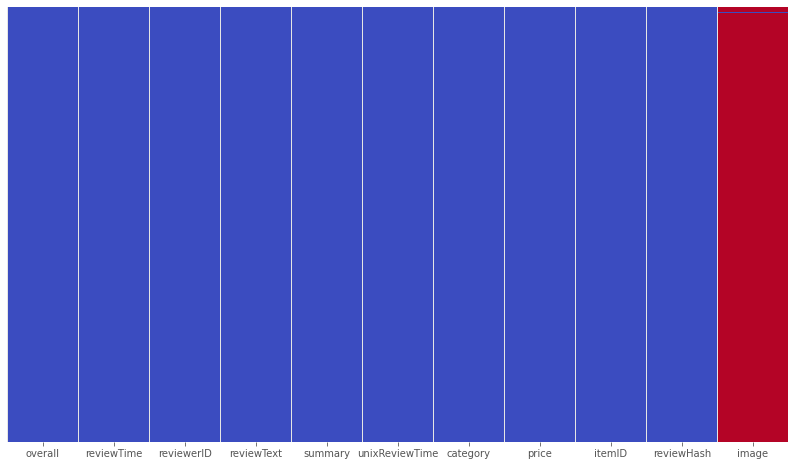

In [ ]:
# Looking at all columns using heatmap to check if their missing data
fig, ax = plt.subplots(figsize=(14,8))
sns.heatmap(DF_train.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)
plt.show()

As we have many missing data in the "image" column (more than 99%), it is better to remove this column. The missing data in "reviewText" and "summary" columns are small (less than 0.01%). According to the fact that it is almost impossible to wrtie a review and summary on behalf of a reviewer/customer and the missing data for these two columns is small in number, it is better to remove the rows with missing data in these two columns.

In [ ]:
# Dropping the "image" column
DF_train.drop(labels='image', axis=1, inplace=True)

# Collecting the indices of the rows containing missing reviews or summaries
ind_summ=DF_train[DF_train['summary'].isnull()].index
ind_rev=DF_train[DF_train['reviewText'].isnull()].index

# Dropping the rows containing missing reviews or summaries
DF_train.drop(ind_summ, axis=0, inplace=True)
# Here, a for loop is defined to neglect the rows with missing reviews that are already remove in the above line due to the missing summary reason
for i in ind_rev:
    if i in DF_train.index:
        DF_train.drop(i, axis=0, inplace=True)

A final check to make sure there is not missing data left


In [ ]:
# Finding the columns with missing data in the training set
for colname in DF_train.columns:
    nullnum=len(DF_train[DF_train[colname].isnull()])
    # Finding other columns that contain null(s).
    if nullnum:
        print(colname, nullnum, nullnum / DF_train.shape[0])
    else:
        print('No missing data in the',colname,'column')

No missing data in the overall column
No missing data in the reviewTime column
No missing data in the reviewerID column
No missing data in the reviewText column
No missing data in the summary column
No missing data in the unixReviewTime column
No missing data in the category column
No missing data in the price column
No missing data in the itemID column
No missing data in the reviewHash column


#### **1.1.1.2 The missing values in the "price" column of the training set**

In [ ]:
ind_miss_pr=[]
for i in DF_train.index:
  
  for index, word in enumerate(DF_train['price'][i]):
    if index == 0:  
      if word[0]!='$':
        ind_miss_pr.append(i)

print('The percentage of the missing prices is: ', (len(ind_miss_pr) / DF_train.shape[0])*100, '%')

The percentage of the missing prices is:  1.3697990650154386 %


Since the number of missing prices is small (about 1.4%) and filling them with appropriate values is almost impossible, it is better to drop the rows with missing prices. 

In [ ]:
DF_train.drop(ind_miss_pr, axis=0, inplace=True)

Final check to see whether there is still any missing prices

In [ ]:
ind_miss_pr=[]
for i in DF_train.index:
 
  for index, word in enumerate(DF_train['price'][i]):
    if index == 0:  
      if word[0]!='$':
        ind_miss_pr.append(i)

if ind_miss_pr == []:
  print('There is no missing price')
else:
  print(ind_miss_pr)

There is no missing price


### **1.1.2 The missing data in the test set**

#### **1.1.2.1 The null values in the test set**

In [ ]:
# Finding the columns with missing data in the training set
for colname in DF_test.columns:
    nullnum=len(DF_test[DF_test[colname].isnull()])
    # Finding other columns that contain null(s).
    if nullnum:
        print(colname, nullnum, nullnum / DF_test.shape[0])

reviewText 3 0.00015
summary 4 0.0002
image 19963 0.99815


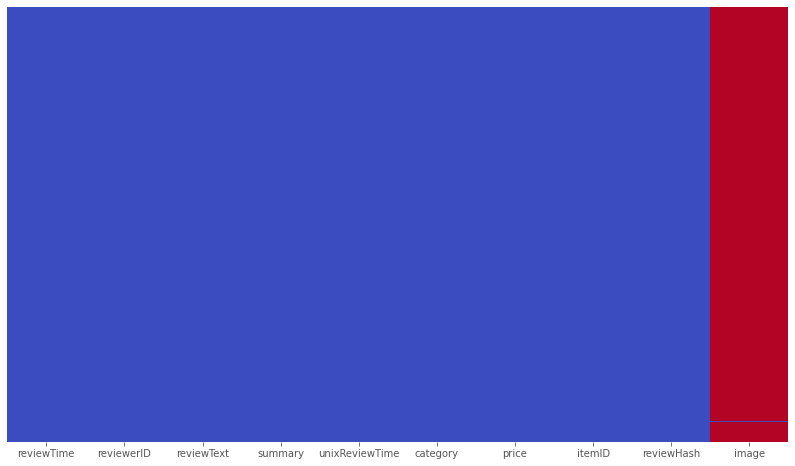

In [ ]:
# Looking at all columns using heatmap to check if their missing data
fig, ax = plt.subplots(figsize=(14,8))
sns.heatmap(DF_test.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)
plt.show()

As we have many missing data in the "image" column (more than 99%), it is better to remove this column. The missing data in "reviewText" and "summary" columns are small (less than 0.03%). It is almost impossible to wrtie a review and summary on behalf of a reviewer/customer and the missing data for these two columns is small in number. Furthermore, we cannot drop the rows containing missing reviews or summaries as we need to submit the complete test set predictions at the end. Therefore, it is better to write 'NaN' in the place of missing review or summaries.

In [ ]:
# Dropping the "image" column
DF_test.drop(labels='image', axis=1, inplace=True)

# Collecting the indices of the rows containing missing reviews or summaries
ind_summ=DF_test[DF_test['summary'].isnull()].index
ind_rev=DF_test[DF_test['reviewText'].isnull()].index

DF_test['summary'][ind_summ]='NaN'
DF_test['reviewText'][ind_rev]='NaN'

In [ ]:
# Finding the columns with missing data in the training set
for colname in DF_test.columns:
    nullnum=len(DF_test[DF_test[colname].isnull()])
    # Finding other columns that contain null(s).
    if nullnum:
        print(colname, nullnum, nullnum / DF_test.shape[0])
    else:
        print('No missing data in the',colname,'column')

No missing data in the reviewTime column
No missing data in the reviewerID column
No missing data in the reviewText column
No missing data in the summary column
No missing data in the unixReviewTime column
No missing data in the category column
No missing data in the price column
No missing data in the itemID column
No missing data in the reviewHash column


#### **1.1.2.2 The missing values in the "price" column of the test set**

In [ ]:
ind_miss_pr=[]
for i in DF_test.index:
  
  for index, word in enumerate(DF_test['price'][i]):
    if index == 0:  
      if word[0]!='$':
        ind_miss_pr.append(i)

print('The percentage of the missing prices is: ', (len(ind_miss_pr) / DF_test.shape[0])*100, '%')

The percentage of the missing prices is:  1.355 %


The number of missing prices is small (about 1.4%) and filling them with appropriate values is almost impossible. Furthermore, due to the reason stated previously for the missing reviews and summaries in the test set, it is not possible to drop the rows containing missing prices. Therefore, it is better to fill them with appropriate values.

For this purpose, the missing prices will be filled with the average of the price of the items in the training set with the same category of the item with missing price.

First by copying the original training  set into a new dataframe, the rows with missing prices are completely dropped in the new dataframe. Then the price is converted to integers and the avarge price for each category is calculated.

In [ ]:
# Creating a new dataframe from the test set by copying it into a new dataframe
new_DF_train=DF_train.copy()

# removing $ sign from the price column
new_DF_train['price'] = new_DF_train['price'].str.replace('$', '')

# converting price column to numerical values
new_DF_train['price'] = pd.to_numeric(new_DF_train['price'])

# Separating the 'category' and 'price' columns into a new dataframe for further analysis
pr_cat=new_DF_train[['category','price']]

In [ ]:
# This for loop fills the missing prices
for i in ind_miss_pr:

  # Getting the description of the category to which the item with missing price belongs to
  des=pr_cat[(pr_cat['category'] == DF_test['category'][i])].describe()

  # converting the average price of the category into string and add the $ sign to its beginning
  price='$'+str(des['price'][1])

  # Adding the new price into the missing value's location
  DF_test['price'][i]=price

Final check to see whether there is still any missing prices

In [ ]:
ind_miss_pr=[]
for i in DF_test.index:
  
  for index, word in enumerate(DF_test['price'][i]):
    if index == 0:  
      if word[0]!='$':
        ind_miss_pr.append(i)

if ind_miss_pr == []:
  print('There is no missing price')
else:
  print(ind_miss_pr)

There is no missing price


### **1.1.3 Creating buckets for the price column**

#### **1.1.3.1 Creating buckets for the price column in the training set**

In [ ]:
# removing $ sign from the price column
DF_train['price'] = DF_train['price'].str.replace('$', '')

In [ ]:
# converting price column to numerical values
DF_train['price'] = pd.to_numeric(DF_train['price'])

In [ ]:
DF_train[['price']].describe()

,price
count,147895.000000
mean,13.712968
std,15.973006
min,0.010000
25%,7.635000
50%,11.280000
75%,15.980000
max,799.990000


In [ ]:
# categorizing price based on statistics
DF_train['price_category'] = pd.cut(DF_train['price'], [-np.inf, 7.64, 11.28, 15.98, np.inf],
                              labels=['low', 'medium', 'high', 'very_high'])

In [ ]:
DF_train.head()

,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,price_category
0,5.0,"08 26, 2014",u92990698,A contemporary jazz and soul performer who's m...,""" CLASSIQUE """,1409011200,Jazz,8.40,p23649501,3856620,medium
1,5.0,"05 11, 2003",u36200649,Very good idea to put both the 'pop' and 'orch...,Exceeded my Expectations - This album RAWKS!,1052611200,Alternative Rock,10.98,p58458313,56086781,medium
2,5.0,"12 5, 2017",u10721702,This is a great collection of Carole King's so...,A Must-have for Carole King Fans,1512432000,Pop,5.99,p97027626,55852154,low
3,5.0,"09 24, 2013",u86003775,The is album is a brilliant piece of Jazz fusi...,A Master piece!,1379980800,Jazz,14.64,p43167086,43228100,high
4,5.0,"01 14, 2015",u25672859,Waited a LONG time for this DVD to be released...,especially if you like concert videos,1421193600,Alternative Rock,9.92,p94494236,54425467,medium


#### **1.1.3.2 Creating buckets for the price column in the test set**

In [ ]:
# removing $ sign from the price column
DF_test['price'] = DF_test['price'].str.replace('$', '')

In [ ]:
# converting price column to numerical values
DF_test['price'] = pd.to_numeric(DF_test['price'])

In [ ]:
DF_test[['price']].describe()

,price
count,20000.000000
mean,13.458673
std,13.322898
min,0.010000
25%,7.740000
50%,11.370000
75%,15.960000
max,799.990000


In [ ]:
# categorizing price based on statistics
DF_test['price_category'] = pd.cut(DF_test['price'], [-np.inf, 7.64, 11.28, 15.98, np.inf],
                              labels=['low', 'medium', 'high', 'very_high'])

In [ ]:
DF_test.head()

,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,price_category
0,"02 11, 2017",u04140621,ok,Five Stars,1486771200,Pop,31.20,p65721979,98944233,very_high
1,"01 29, 2018",u74766187,The 1955 and 1958 sets alone are worth the pur...,Buy It For the 1955 Set With Monk!,1517184000,Jazz,34.04,p87809670,33903910,very_high
2,"08 29, 2005",u31689638,Mary J Blige is someone most people know of. S...,Mary's excellent debut! Classic!,1125273600,Pop,1.72,p52702240,35386470,low
3,"11 2, 2015",u35613516,Very good satch album,Four Stars,1446422400,Pop,10.99,p01314374,12404766,medium
4,"01 3, 2012",u93320378,Well there are hundreds of Christmas anthologi...,CD lives up to its name,1325548800,Alternative Rock,7.98,p84396269,68253688,medium


### **1.1.4 Creating buckets for the "unixReviewTime" column**

#### **1.1.4.1 Creating buckets for the "unixReviewTime" column in the test set**

In [ ]:
# converting unixReviewTime column to numerical values
DF_test['unixReviewTime'] = pd.to_numeric(DF_test['unixReviewTime'])

In [ ]:
DF_test[['unixReviewTime']].describe()

,unixReviewTime
count,2.000000e+04
mean,1.283571e+09
std,1.715204e+08
min,8.937216e+08
25%,1.128643e+09
50%,1.352290e+09
75%,1.427674e+09
max,1.538266e+09


In [ ]:
# categorizing unixReviewTime based on statistics
DF_test['time_category'] = pd.cut(DF_test['unixReviewTime'], [-np.inf, 1.127693e+09, 1.353715e+09, 1.428019e+09, np.inf],
                              labels=['older_than_2006', '2006_2013', '2013_2015', '2015_present'])

In [ ]:
DF_test.head()

,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,price_category,time_category
0,"02 11, 2017",u04140621,ok,Five Stars,1486771200,Pop,31.20,p65721979,98944233,very_high,2015_present
1,"01 29, 2018",u74766187,The 1955 and 1958 sets alone are worth the pur...,Buy It For the 1955 Set With Monk!,1517184000,Jazz,34.04,p87809670,33903910,very_high,2015_present
2,"08 29, 2005",u31689638,Mary J Blige is someone most people know of. S...,Mary's excellent debut! Classic!,1125273600,Pop,1.72,p52702240,35386470,low,older_than_2006
3,"11 2, 2015",u35613516,Very good satch album,Four Stars,1446422400,Pop,10.99,p01314374,12404766,medium,2015_present
4,"01 3, 2012",u93320378,Well there are hundreds of Christmas anthologi...,CD lives up to its name,1325548800,Alternative Rock,7.98,p84396269,68253688,medium,2006_2013


#### **1.1.4.2 Creating buckets for the "unixReviewTime" column in the training set**

In [ ]:
# converting unixReviewTime column to numerical values
DF_train['unixReviewTime'] = pd.to_numeric(DF_train['unixReviewTime'])

In [ ]:
DF_train[['unixReviewTime']].describe()

,unixReviewTime
count,1.478950e+05
mean,1.284875e+09
std,1.708878e+08
min,8.878464e+08
25%,1.129939e+09
50%,1.353542e+09
75%,1.427328e+09
max,1.537661e+09


In [ ]:
# categorizing unixReviewTime based on statistics
DF_train['time_category'] = pd.cut(DF_train['unixReviewTime'], [-np.inf, 1.129939e+09, 1.353542e+09, 1.427328e+09, np.inf],
                              labels=['older_than_2006', '2006_2013', '2013_2015', '2015_present'])

In [ ]:
DF_train.head()

,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,price_category,time_category
0,5.0,"08 26, 2014",u92990698,A contemporary jazz and soul performer who's m...,""" CLASSIQUE """,1409011200,Jazz,8.40,p23649501,3856620,medium,2013_2015
1,5.0,"05 11, 2003",u36200649,Very good idea to put both the 'pop' and 'orch...,Exceeded my Expectations - This album RAWKS!,1052611200,Alternative Rock,10.98,p58458313,56086781,medium,older_than_2006
2,5.0,"12 5, 2017",u10721702,This is a great collection of Carole King's so...,A Must-have for Carole King Fans,1512432000,Pop,5.99,p97027626,55852154,low,2015_present
3,5.0,"09 24, 2013",u86003775,The is album is a brilliant piece of Jazz fusi...,A Master piece!,1379980800,Jazz,14.64,p43167086,43228100,high,2013_2015
4,5.0,"01 14, 2015",u25672859,Waited a LONG time for this DVD to be released...,especially if you like concert videos,1421193600,Alternative Rock,9.92,p94494236,54425467,medium,2013_2015


## **1.2 Pre-Processing (Applying Cleaning Functions)**

In any machine learning task, data cleaning and pre-processing is extremely important. As can be seen from dataset, the review texts are not in a suitable form for analysis and contain too much noise. 

Here, we intend to design a procedure that prepares text data for analysis by satisying the requirements. Some potential techniques can be as follows:

- Removal of stop words
- Removal of punctuations
- Lower casing
- Removal of URLs and HTML tags
- Lemmatization

In [ ]:
# Importing additional libraries for data cleaning and pre-processing
import nltk
nltk.download('punkt')
import contractions
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from contractions import contractions_dict

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### **1.2.1 Removal of HTML Tags**
We can use BeautifulSoup package for removing HTML tags in a more elegant way.

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

### **1.2.2 Removal of Between Square Brackets**

In [ ]:
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

### **1.2.3 Removal of Special Characters**

In [ ]:
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

### **1.2.4 Removal of Non-ASCII Characters**
Removing non-ASCII characters results in a string that only contains ASCII characters. For example, removing non-ASCII characters from "àa string withé fuünny charactersß" results in "a string with funny characters".

In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

### **1.2.5 Lower Casing**

It is a common text preprocessing technique. The idea is to convert the input text into same casing format so that 'text', 'Text' and 'TEXT' are treated the same way.

In [ ]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

### **1.2.6 Removal of Punctuations**

In [ ]:
def remove_punctuation_and_splchars(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_word = remove_special_characters(new_word, True)
            new_words.append(new_word)
    return new_words

### **1.2.7 Replacing Numbers**

In [ ]:
def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

### **1.2.8 Removing StopWords**

Stopwords are commonly occuring words in a language like 'the', 'a' and so on. They can be removed from the text, as they don't provide valuable information for downstream analysis.

In [ ]:
stopword_list= stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

### **1.2.9 Stemming**

For grammatical reasons, documents are going to use different forms of a word, such as organize, organizes, and organizing. Additionally, there are families of derivationally related words with similar meanings, such as democracy, democratic, and democratization. In many situations, it seems as if it would be useful for a search for one of these words to return documents that contain another word in the set.

The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

In [ ]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

### **1.2.10 Lemmatization**

In [ ]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def lemmatize(words):
    lemmas = lemmatize_verbs(words)
    return lemmas

In [ ]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation_and_splchars(words)
    words = remove_stopwords(words)
    return words

In [ ]:
def normalize_and_lemmatize(input):
    sample = denoise_text(input)
    sample = remove_special_characters(sample)
    words = nltk.word_tokenize(sample)
    words = normalize(words)
    lemmas = lemmatize(words)
    return ' '.join(lemmas)

### **1.2.11 Applying the above functions on the training and test sets**

In [ ]:
# Applying Cleaning functions defined above on Train dataset 
DF_train['reviewText_clean'] = DF_train['reviewText'].apply(lambda x: normalize_and_lemmatize(x))
DF_train['summary_clean'] = DF_train['summary'].apply(lambda x: normalize_and_lemmatize(x))

In [ ]:
DF_train.head(2)

,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,price_category,time_category,reviewText_clean,summary_clean
0,5.0,"08 26, 2014",u92990698,A contemporary jazz and soul performer who's m...,""" CLASSIQUE """,1409011200,Jazz,8.40,p23649501,3856620,medium,2013_2015,contemporary jazz soul performer whos make two...,classique
1,5.0,"05 11, 2003",u36200649,Very good idea to put both the 'pop' and 'orch...,Exceeded my Expectations - This album RAWKS!,1052611200,Alternative Rock,10.98,p58458313,56086781,medium,older_than_2006,good idea put pop orchestral music matrix relo...,exceed expectations album rawks


In [ ]:
# Applying Cleaning functions defined above on Test dataset 
DF_test['reviewText_clean'] = DF_test['reviewText'].apply(lambda x: normalize_and_lemmatize(x))
DF_test['summary_clean'] = DF_test['summary'].apply(lambda x: normalize_and_lemmatize(x))

In [ ]:
DF_test.head(2)

,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,price_category,time_category,reviewText_clean,summary_clean
0,"02 11, 2017",u04140621,ok,Five Stars,1486771200,Pop,31.20,p65721979,98944233,very_high,2015_present,ok,five star
1,"01 29, 2018",u74766187,The 1955 and 1958 sets alone are worth the pur...,Buy It For the 1955 Set With Monk!,1517184000,Jazz,34.04,p87809670,33903910,very_high,2015_present,set alone worth purchase cost everything else ...,buy set monk


# **2 Exploratory Data Analysis** 

### **2.1 Exploring target column**

The frequency distribution of the review’s rating shows that users rated music mainly on a scale of 5 star where the number of occurrences was around 95000, while the other occurrence of music rating was mostly positive. See figure below for further details.


In [ ]:
DF_train['overall'].describe()

count    147895.000000
mean          4.411197
std           0.994805
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [ ]:
DF_train['overall'].value_counts()

5.0    96994
4.0    29163
3.0    11951
2.0     5132
1.0     4655
Name: overall, dtype: int64

In [ ]:
#Exploring Target Variable
ratings = DF_train['overall']
ratings_dis = ratings.value_counts()

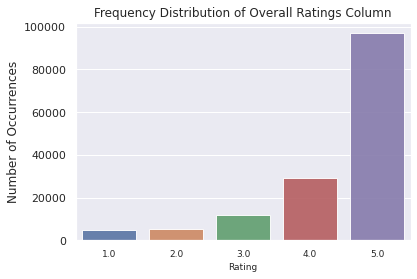

In [ ]:
sns.set(style="darkgrid")
sns.barplot(ratings_dis.index, ratings_dis.values, alpha=0.9)
plt.title('Frequency Distribution of Overall Ratings Column')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(fontsize=9)
plt.xlabel('Rating', fontsize=9)
plt.show()

### **2.2 Visualising text columns**

The word cloud was plotted to see which words or phrases are being used the most in the reviewtext_clean and summary_clean. Some of the most popular words in the reviewtext_clean column were album, classique, original, one, love,etc. 

While for the summary_clean column the most popular words are album, exceed, carole, classique, expectations, etc.

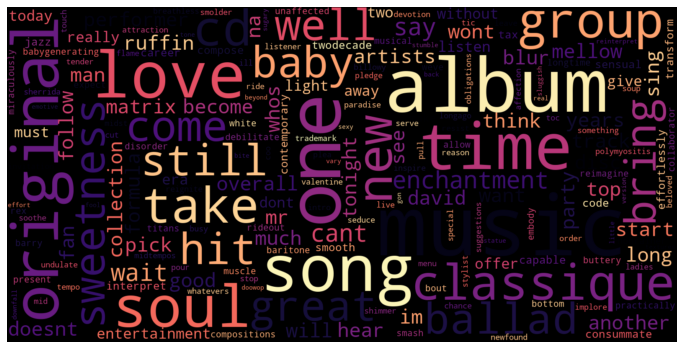

In [ ]:
#Generating wordcloud figure for cleaned reviews in the training df
review_vis = DF_train['reviewText_clean'].values
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,random_state=0,colormap='magma').generate(str(review_vis))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

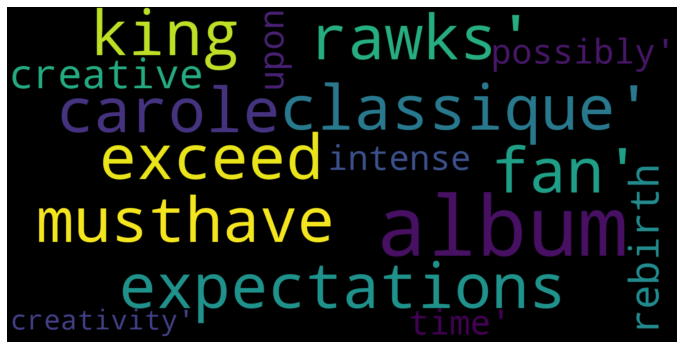

In [ ]:
#Generating wordcloud figure for cleaned summaries in the training df
summary_vis = DF_train['summary_clean'].values
wordcloud = WordCloud(width=1600, height=800,random_state=0,max_font_size=200).generate(str(summary_vis))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### **2.3 Exploring trends between features**

Exploring the price categorization of different genres of music, we can see that the price range of Pop, Alternative Rock, and Dance & Electronic music is distributed more towards the lower and medium price range, while Jazz and Classical are considered more expensive type of genres from the data. Pop can be seen  as the most popular genre in the last decade at the expense of alternative rock which has been declining in popularity since 2006. Jazz and Classical are growing in popularity but at a very minor pace. 

In [ ]:
DF_train.category.value_counts()

Pop                   67963
Alternative Rock      42022
Jazz                  14691
Classical             13915
Dance & Electronic     9304
Name: category, dtype: int64

In [ ]:
DF_train.price_category.value_counts()

high         37674
medium       37030
low          36982
very_high    36209
Name: price_category, dtype: int64

In [ ]:
DF_train.time_category.value_counts()

2013_2015          36988
2006_2013          36973
2015_present       36967
older_than_2006    36967
Name: time_category, dtype: int64

In [ ]:
#Contructing data for plotting

pop_vis = DF_train[DF_train['category'] == 'Pop']
pop_low = len(pop_vis[pop_vis['price_category'] == 'low'])
pop_mid = len(pop_vis[pop_vis['price_category'] == 'medium'])
pop_high = len(pop_vis[pop_vis['price_category'] == 'high'])
pop_vhigh = len(pop_vis[pop_vis['price_category'] == 'very_high'])

alt_rock_vis = DF_train[DF_train['category'] == 'Alternative Rock']
alt_rock_low = len(alt_rock_vis[alt_rock_vis['price_category'] == 'low'])
alt_rock_mid = len(alt_rock_vis[alt_rock_vis['price_category'] == 'medium'])
alt_rock_high = len(alt_rock_vis[alt_rock_vis['price_category'] == 'high'])
alt_rock_vhigh = len(alt_rock_vis[alt_rock_vis['price_category'] == 'very_high'])

jazz_vis = DF_train[DF_train['category'] == 'Jazz']
jazz_low = len(jazz_vis[jazz_vis['price_category'] == 'low'])
jazz_mid = len(jazz_vis[jazz_vis['price_category'] == 'medium'])
jazz_high = len(jazz_vis[jazz_vis['price_category'] == 'high'])
jazz_vhigh = len(jazz_vis[jazz_vis['price_category'] == 'very_high'])

classical_vis = DF_train[DF_train['category'] == 'Classical']
classical_low = len(classical_vis[classical_vis['price_category'] == 'low'])
classical_mid = len(classical_vis[classical_vis['price_category'] == 'medium'])
classical_high = len(classical_vis[classical_vis['price_category'] == 'high'])
classical_vhigh = len(classical_vis[classical_vis['price_category'] == 'very_high'])

dne_vis = DF_train[DF_train['category'] == 'Dance & Electronic']
dne_low = len(dne_vis[dne_vis['price_category'] == 'low'])
dne_mid = len(dne_vis[dne_vis['price_category'] == 'medium'])
dne_high = len(dne_vis[dne_vis['price_category'] == 'high'])
dne_vhigh = len(dne_vis[dne_vis['price_category'] == 'very_high'])


low = [pop_low, alt_rock_low, jazz_low, classical_low, dne_low]
medium = [pop_mid, alt_rock_mid, jazz_mid, classical_mid, dne_mid]
high = [pop_high, alt_rock_high, jazz_high, classical_high, dne_high]
very_high = [pop_vhigh, alt_rock_vhigh, jazz_vhigh, classical_vhigh, dne_vhigh]

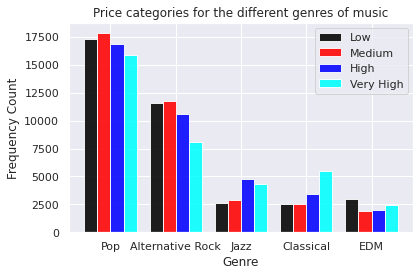

In [ ]:
#Plotting the bar chart
fig, ax = plt.subplots()
idx = np.arange(5)
bar_width = 0.2
opacity = 0.88

plt.bar(idx-bar_width, low, bar_width, alpha=opacity, 
        color='black', label='Low')

plt.bar(idx, medium, bar_width, alpha=opacity, 
         color='red', label='Medium')

plt.bar(idx + bar_width, high, bar_width, alpha=opacity, 
        color='blue', edgecolor='white', label='High')

plt.bar(idx + 2*bar_width, very_high, bar_width, alpha=opacity,
        color='cyan', edgecolor='white', label='Very High')

plt.xlabel('Genre')
plt.ylabel('Frequency Count')
plt.title('Price categories for the different genres of music')
plt.xticks(idx + bar_width/2, ('Pop', 'Alternative Rock', 'Jazz', 'Classical', 'EDM'))
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Contructing data for plotting

pop_vis_time = DF_train[DF_train['category'] == 'Pop']
pop_pre06 = len(pop_vis_time[pop_vis_time['time_category'] == 'older_than_2006'])
pop_0613 = len(pop_vis_time[pop_vis_time['time_category'] == '2006_2013'])
pop_1315 = len(pop_vis_time[pop_vis_time['time_category'] == '2013_2015'])
pop_15pres = len(pop_vis_time[pop_vis_time['time_category'] == '2015_present'])

alt_rock_vis_time = DF_train[DF_train['category'] == 'Alternative Rock']
alt_rock_pre06 = len(alt_rock_vis_time[alt_rock_vis_time['time_category'] == 'older_than_2006'])
alt_rock_0613 = len(alt_rock_vis_time[alt_rock_vis_time['time_category'] == '2006_2013'])
alt_rock_1315 = len(alt_rock_vis_time[alt_rock_vis_time['time_category'] == '2013_2015'])
alt_rock_15pres = len(alt_rock_vis_time[alt_rock_vis_time['time_category'] == '2015_present'])

jazz_vis_time = DF_train[DF_train['category'] == 'Jazz']
jazz_pre06 = len(jazz_vis_time[jazz_vis_time['time_category'] == 'older_than_2006'])
jazz_0613 = len(jazz_vis_time[jazz_vis_time['time_category'] == '2006_2013'])
jazz_1315 = len(jazz_vis_time[jazz_vis_time['time_category'] == '2013_2015'])
jazz_15pres = len(jazz_vis_time[jazz_vis_time['time_category'] == '2015_present'])

classical_vis_time = DF_train[DF_train['category'] == 'Classical']
classical_pre06 = len(classical_vis_time[classical_vis_time['time_category'] == 'older_than_2006'])
classical_0613 = len(classical_vis_time[classical_vis_time['time_category'] == '2006_2013'])
classical_1315 = len(classical_vis_time[classical_vis_time['time_category'] == '2013_2015'])
classical_15pres = len(classical_vis_time[classical_vis_time['time_category'] == '2015_present'])

dne_vis_time = DF_train[DF_train['category'] == 'Dance & Electronic']
dne_pre06 = len(dne_vis_time[dne_vis_time['time_category'] == 'older_than_2006'])
dne_0613 = len(dne_vis_time[dne_vis_time['time_category'] == '2006_2013'])
dne_1315 = len(dne_vis_time[dne_vis_time['time_category'] == '2013_2015'])
dne_15pres = len(dne_vis_time[dne_vis_time['time_category'] == '2015_present'])


pre06 = [pop_pre06, alt_rock_pre06, jazz_pre06, classical_pre06, dne_pre06]
btwn0613 = [pop_0613, alt_rock_0613, jazz_0613, classical_0613, dne_0613]
btwn1315 = [pop_1315, alt_rock_1315, jazz_1315, classical_1315, dne_1315]
post15 = [pop_15pres, alt_rock_15pres, jazz_15pres, classical_15pres, dne_15pres]

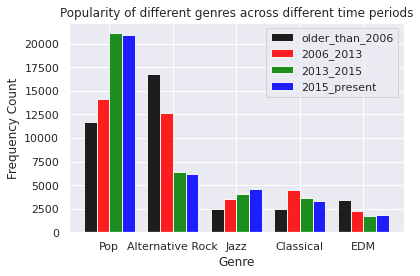

In [ ]:
#Plotting the bar chart
fig, ax = plt.subplots()
idx = np.arange(5)
bar_width = 0.2
opacity = 0.88

plt.bar(idx-bar_width, pre06, bar_width, alpha=opacity, 
        color='black', label='older_than_2006')

plt.bar(idx, btwn0613, bar_width, alpha=opacity, 
         color='red', label='2006_2013')

plt.bar(idx + bar_width, btwn1315, bar_width, alpha=opacity, 
        color='green', edgecolor='white', label='2013_2015')

plt.bar(idx + 2*bar_width, post15, bar_width, alpha=opacity,
        color='blue', edgecolor='white', label='2015_present')

plt.xlabel('Genre')
plt.ylabel('Frequency Count')
plt.title('Popularity of different genres across different time periods')
plt.xticks(idx + bar_width/2, ('Pop', 'Alternative Rock', 'Jazz', 'Classical', 'EDM'))
plt.legend()

plt.tight_layout()
plt.show()

### **2.4 Visualising order of feature importance**

From the non-textual features, the most important features with respect to predicting the rating of a record, were deduced by calculating the correlation between all the feature columns and the target column (rating). The most important features in order of feture importance (correlation score) were found to be: unixReviewTime, price, reviewHash

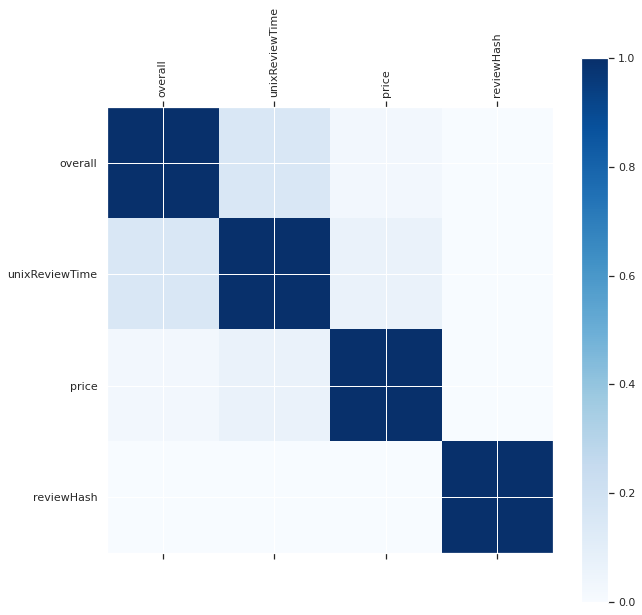

In [ ]:
#Deriving Correlation Matrix
corr_mat = DF_train.corr()

#Finding correlations to rating column
ratings_corr = corr_mat["overall"]

#Identifying most important features
most_imp = list(ratings_corr.nlargest().index)

#Plotting Correlation Matrix
c = corr_mat.loc[most_imp, most_imp]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(c, vmin=0, vmax=1,cmap=plt.cm.Blues)
fig.colorbar(cax)
ticks = np.arange(0,len(ratings_corr),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(c.index,rotation=90)
ax.set_yticklabels(c.index)
plt.show()

In [ ]:
ratings_corr

overall           1.000000
unixReviewTime    0.151206
price             0.024311
reviewHash        0.003663
Name: overall, dtype: float64

The relationships between the category (genre), price category, and time category were further investigated to understand their influence on the rating received

In [ ]:
DF_train.overall.groupby(DF_train["category"]).mean()

category
Alternative Rock      4.295893
Classical             4.519727
Dance & Electronic    4.422506
Jazz                  4.541488
Pop                   4.430558
Name: overall, dtype: float64

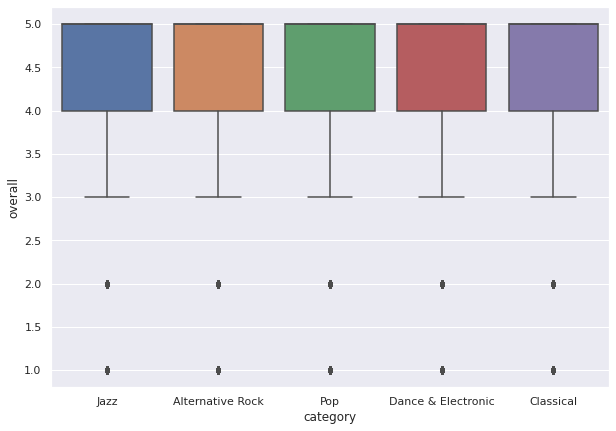

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(x='category', y='overall', data=DF_train)
plt.show()

No real correlation between category (genre) and the ratings received, as all genres received an average rating over 4, as seen above

In [ ]:
DF_train.overall.groupby(DF_train["price_category"]).mean()

price_category
low          4.358309
medium       4.395760
high         4.428518
very_high    4.462979
Name: overall, dtype: float64

No real correlation between price category and the ratings received, as all price categories received an average rating over 4, as seen in the cell above

In [ ]:
DF_train.overall.groupby(DF_train["time_category"]).mean()

time_category
older_than_2006    4.234561
2006_2013          4.254185
2013_2015          4.536606
2015_present       4.619390
Name: overall, dtype: float64

No real correlation between time category and the ratings received, as all time periods received an average rating over 4, as seen in the cell above

### **2.5 Visualising Ratings Review Text Length Distribution**

In [ ]:
DF_train['length'] = DF_train['reviewText_clean'].apply(len)
DF_train.length.describe()

count    147895.000000
mean        446.967592
std         635.354328
min           0.000000
25%          63.000000
50%         221.000000
75%         583.000000
max       17378.000000
Name: length, dtype: float64

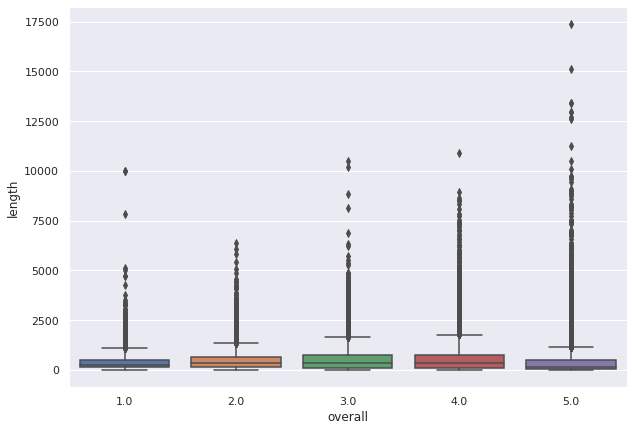

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(x='overall', y='length', data=DF_train)
plt.show()

The higher ratings appear to have longer reviews

# **3 Feature Extraction, Engineering and Preprocessing** 

### **3.1 One-Hot Encoding of Categorical Features**
The following 2 features in our dataset are categorical and therefore will be one-hot encoded:
 - category
 - time_category

In [ ]:
# ohe of 'category' and 'time_category'
# train 
dummy = pd.get_dummies(data=DF_train[['category', 'time_category']], prefix=['category', 'time_category'], drop_first=True)
DF_train_clean = pd.concat([DF_train, dummy], axis=1)
DF_train_clean.drop(columns=['category', 'time_category'], axis=1, inplace=True)

# test
dummy = pd.get_dummies(data=DF_test[['category', 'time_category']], prefix=['category', 'time_category'], drop_first=True)
DF_test_clean = pd.concat([DF_test, dummy], axis=1)
DF_test_clean.drop(columns=['category', 'time_category'], axis=1, inplace=True)

### **3.2 Ordinal Encoding of Categories with Order**
The price_category follows a nominal order, that is low, medium, high, very high. Hence, this will be mapped in a nominal fashion. 

In [ ]:
# train
price_ranking = {'low': 1, 'medium': 2, 'high': 3, 'very_high': 4}
DF_train_clean['price_category'] = DF_train['price_category'].map(price_ranking)

# test
DF_test_clean['price_category'] = DF_test['price_category'].map(price_ranking)

### **3.3 Additional Feature Generation**
In this section, 2 additional features are generated:
- we combine the review and summary text into a single column
- we introduce 'polarity_score' based on the all textual data using TextBlob library (a simple NLP library that assigns a polary rating to a string between -1 (negative) and +1 (positive))

In [ ]:
### COMBINING REVIEWTEXT AND SUMMARY INTO ONE COLUMN ###

# combining summary and reviewText in both Train and Test set
DF_train_clean['all_text'] = DF_train_clean['reviewText_clean'] + ' ' + DF_train_clean['summary_clean']
DF_test_clean['all_text'] = DF_test_clean['reviewText_clean'] + ' ' + DF_test_clean['summary_clean']

### POLARITY SCORE BASED ON TEXTUAL DATA ###

# obtain polarity score using textBlob library
def textBlob_polarity(string_literal):
    # This polarity score is between -1 (negative) to 1 (positive)
    polarity = TextBlob(string_literal).sentiment.polarity
    return polarity

# create feature in both train and test dataset
DF_train_clean['polarity_score'] = DF_train_clean['all_text'].apply(lambda x: textBlob_polarity(x))
DF_test_clean['polarity_score'] = DF_test_clean['all_text'].apply(lambda x: textBlob_polarity(x))

### **3.4 Train Test Split and Normalization**
The data is split into 2 portions: 
- Training: Used for model training
- Validation: This will be the portion of data utilized to test the trained model

The numerical features are than normalized between 0 and 1 to bring them all to same scale. This is particularly important when using regression and neural network models.

In [ ]:
# selecting specific features from the test set that will be used in the model
# we are essentially using all features in the data (this is just a step to make sure code will not crash from prior sections)
DF_test_clean = DF_test_clean[['price', 'price_category', 'category_Classical', 'category_Dance & Electronic', 'category_Jazz', 'category_Pop', 'time_category_2006_2013', 'time_category_2013_2015', 'time_category_2015_present', 'polarity_score', 'all_text']]

# split the training data into train and validation set
X_overall = DF_train_clean[['price', 'price_category', 'category_Classical', 'category_Dance & Electronic', 'category_Jazz', 'category_Pop', 'time_category_2006_2013', 'time_category_2013_2015', 'time_category_2015_present', 'polarity_score', 'all_text']]
y = DF_train_clean['overall']
X_train, X_val, y_train, y_val = train_test_split(X_overall, y, test_size=0.5, random_state=0)

In [ ]:
# normalization between 0 and 1
# sc = StandardScaler()
mms = MinMaxScaler()
X_train_std = X_train.copy()
X_val_std = X_val.copy()
DF_test_std = DF_test_clean.copy()
X_train_std[['price', 'price_category', 'polarity_score']] = mms.fit_transform(X_train[['price', 'price_category', 'polarity_score']])
X_val_std[['price', 'price_category', 'polarity_score']] = mms.transform(X_val[['price', 'price_category', 'polarity_score']])
DF_test_std[['price', 'price_category', 'polarity_score']] = mms.transform(DF_test_clean[['price', 'price_category', 'polarity_score']])

### **3.4 Feature Extraction of Text Data**
TF-IDF (along with n-gram) was used to extract data from the textual. The TF-IDF vector is then horizontally stacked with other numerical features from before (category, price etc.) to combine all features together into one array.

In [ ]:
# tf-idf on train and test
tfidfVec = TfidfVectorizer(max_features=2500, ngram_range=(1,3))
X_trn_tfidf = tfidfVec.fit_transform(X_train_std['all_text'])
X_val_tfidf = tfidfVec.transform(X_val_std['all_text'])
DF_test_tfidf = tfidfVec.transform(DF_test_std['all_text'])

In [ ]:
# collecting text features, OHE features, numerical features together on training
X_train_final = np.hstack([X_train_std.drop('all_text', axis=1).to_numpy(), X_trn_tfidf.toarray()])

In [ ]:
# collecting text features, OHE features, numerical features together on validation
X_val_final = np.hstack([X_val_std.drop('all_text', axis=1).to_numpy(), X_val_tfidf.toarray()])

In [ ]:
# collecting text features, OHE features, numerical features together on testing
DF_test_final = np.hstack([DF_test_std.drop('all_text', axis=1).to_numpy(), DF_test_tfidf.toarray()])

## **4 Machine Learning and Model Implementation**



### **4.1 Baseline Model: Ridge Regression Approach**
Firstly, a baseline model is designed using ridge regression algorithm. This will give a good baseline on what kind of results to expect when advanced and more complex approaches are looked at later on.

In [ ]:
# model training and prediction
gridParam = {'alpha': [0.01, 0.1, 1, 10]}
ridReg = Ridge(normalize=False)
model_gridCV = GridSearchCV(ridReg, gridParam, cv=5, scoring='neg_mean_squared_error')
model_gridCV.fit(X_train_final, y_train)
print(model_gridCV.best_estimator_)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)


In [ ]:
# use best model and fit on training data
best_mod = model_gridCV.best_estimator_
best_mod.fit(X_train_final, y_train)

# predict on training, validation and actual test data
y_pred_train = best_mod.predict(X_train_final)
y_pred_val = best_mod.predict(X_val_final)
y_pred_test = best_mod.predict(DF_test_final) 

def rounding_procedure(list_input):
  """
  This rounding procedure ensures all ratings fall between 1 and 5
  """
  list_output = []
  for i in list_input:
    if i < 1:
      list_output.append(1)
    elif i > 5:
      list_output.append(5)
    else:
      list_output.append(i)
  return list_output

# rating correction: round ratings below 1 to 1 and ratings above 5 to 5
y_pred_train_corr = rounding_procedure(y_pred_train)
y_pred_val_corr = rounding_procedure(y_pred_val)
y_pred_tst_corr = rounding_procedure(y_pred_test)

# calculate mse on training and validation
y_train_mse = mean_squared_error(y_train, y_pred_train_corr) 
y_val_mse = mean_squared_error(y_val, y_pred_val_corr)

In [ ]:
# putting all predictions in dataFrame (will be used later to ensemble)
y_pred_trn_df_baseline = pd.DataFrame(y_pred_train_corr, columns=['prediction_baseline'])
y_pred_val_df_baseline = pd.DataFrame(y_pred_val_corr, columns=['prediction_baseline'])
y_pred_tst_df_baseline = pd.DataFrame(y_pred_tst_corr, columns=['prediction_baseline'])

In [ ]:
print("Result with Ridge Regression Model\n")
print("MSE on training set = {:.3f}".format(y_train_mse))
print("MSE on testing set = {:.3f}".format(y_val_mse))

Result with Ridge Regression Model

MSE on training set = 0.492
MSE on testing set = 0.521


In [ ]:
ridge_train = y_train_mse.copy()
ridge_test = y_val_mse.copy()

The above results give us an starting point on what to expect from our model. The Mean Squared Error on both training and testing set is very close, indicating that model has a good fit. Next, more advanced approaches will be looked at to see if MSE can be further reduced.

### **4.2 XGB Modelling Approach**
A Gradient Boosted Decision Tree model will be used in conjunction with grid search to find the best resulting model. 

In [ ]:
#best hyperparameters hard coded due to long computational time
#gridParam = {'max_depth': [4,7,10], 'n_estimators': [50,100], 'min_child_weight': [5,8]}

gridParam = {'max_depth': [7], 'n_estimators': [100], 'min_child_weight': [8]}
xgbReg = XGBRegressor(objective='reg:squarederror')
xgb_gridCV = GridSearchCV(xgbReg, gridParam, cv=5, scoring='neg_mean_squared_error')
xgb_gridCV.fit(X_train_final, y_train)

# predict on training, validation and actual test data
y_pred_train_xgb = xgb_gridCV.predict(X_train_final)
y_pred_val_xgb = xgb_gridCV.predict(X_val_final)
y_pred_test_xgb = xgb_gridCV.predict(DF_test_final) 

# rating correction: round ratings below 1 to 1 and ratings above 5 to 5
y_pred_train_corr_xgb = rounding_procedure(y_pred_train_xgb)
y_pred_val_corr_xgb = rounding_procedure(y_pred_val_xgb)
y_pred_tst_corr_xgb = rounding_procedure(y_pred_test_xgb)

# calculate mse on training and validation
y_train_mse_xgb = mean_squared_error(y_train, y_pred_train_corr_xgb) 
y_val_mse_xgb = mean_squared_error(y_val, y_pred_val_corr_xgb)

print("Result with XG Decision Trees Model\n")
print("MSE on training set = {:.3f}".format(y_train_mse_xgb))
print("MSE on testing set = {:.3f}".format(y_val_mse_xgb))

In [ ]:
xgb_train = y_train_mse_xgb.copy()
xgb_test = y_val_mse_xgb.copy()

### **4.3 Bi-LSTM Model with 2 Input Layers**
In this approach, a bidirectional LSTM method is explored using 2 input layers as following:
1. Word Embedded for Text
2. Other Features (Price, Category, etc.)

Bi-directional LSTM models are excellent in NLP tasks because they allow the neural network to have both forward and backward information about a sequence at every time. Because the inputs are run both from past to future as well as from future to past, they are much better at understanding the context of user-input texts.

The word embedding was obtained using pre-trained word vectors through GloVe.

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Dense, LSTM, Input, Bidirectional, Embedding, Concatenate
from keras.regularizers import l2

In [ ]:
# input_1 (all text)
X_train_txt = X_train_std['all_text']
X_val_txt = X_val_std['all_text']
X_test_txt = DF_test_std['all_text']

# input_2 (all other features)
X_train_others = X_train_std.iloc[:,:-1]
X_val_others = X_val_std.iloc[:,:-1]
X_test_others = DF_test_std.iloc[:,:-1]

In [ ]:
# tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_txt)

# convert tokens to sequence
X_train_txt = tokenizer.texts_to_sequences(X_train_txt)
X_val_txt = tokenizer.texts_to_sequences(X_val_txt)
X_test_txt = tokenizer.texts_to_sequences(X_test_txt)

vocab_size = len(tokenizer.word_index) + 1
maxlen = 250

# pre-pad sequence with 0s
X_train_txt = pad_sequences(X_train_txt, padding='pre', maxlen=maxlen)
X_val_txt = pad_sequences(X_val_txt, padding='pre', maxlen=maxlen)
X_test_txt = pad_sequences(X_test_txt, padding='pre', maxlen=maxlen)

In [ ]:
# embed using pre-trained glove
embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
# input_1 is for text. input_2 is for other features
input_1 = Input(shape=(maxlen,))
input_2 = Input(shape=(10,))

In [ ]:
# define word embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer_1 = Bidirectional(LSTM(128))(embedding_layer)

# define layer for other features (numerical, one-hot encoded etc)
dense_layer_1 = Dense(18, activation='relu')(input_2)

In [ ]:
# concatenating both input layers
concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_1])

# add hidden layers with dropout between
dense_layer_2 = Dense(18, activation='relu')(concat_layer)
dropout_layer_1 = Dropout(0.01)(dense_layer_2)
dense_layer_3 = Dense(9, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.01)(dense_layer_3)

# output layer
output = Dense(1, activation='linear')(dropout_layer_2)

# setup model
model = Model(inputs=[input_1, input_2], outputs=output)

In [ ]:
# compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanSquaredError'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 250, 100)     14621600    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256)          234496      embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
# fit model 
lstm_mod = model.fit(x=[X_train_txt, X_train_others], y=y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.3)

Epoch 1/10
405/405 [==============================] - 52s 45ms/step - loss: 2.4256 - mean_squared_error: 2.4256 - val_loss: 0.6988 - val_mean_squared_error: 0.6988
Epoch 2/10
405/405 [==============================] - 18s 44ms/step - loss: 0.7776 - mean_squared_error: 0.7776 - val_loss: 0.6497 - val_mean_squared_error: 0.6497
Epoch 3/10
405/405 [==============================] - 18s 44ms/step - loss: 0.6637 - mean_squared_error: 0.6637 - val_loss: 0.5781 - val_mean_squared_error: 0.5781
Epoch 4/10
405/405 [==============================] - 18s 45ms/step - loss: 0.5935 - mean_squared_error: 0.5935 - val_loss: 0.5785 - val_mean_squared_error: 0.5785
Epoch 5/10
405/405 [==============================] - 18s 45ms/step - loss: 0.5630 - mean_squared_error: 0.5630 - val_loss: 0.5946 - val_mean_squared_error: 0.5946
Epoch 6/10
405/405 [==============================] - 18s 46ms/step - loss: 0.5469 - mean_squared_error: 0.5469 - val_loss: 0.5242 - val_mean_squared_error: 0.5242
Epoch 7/10
405/4

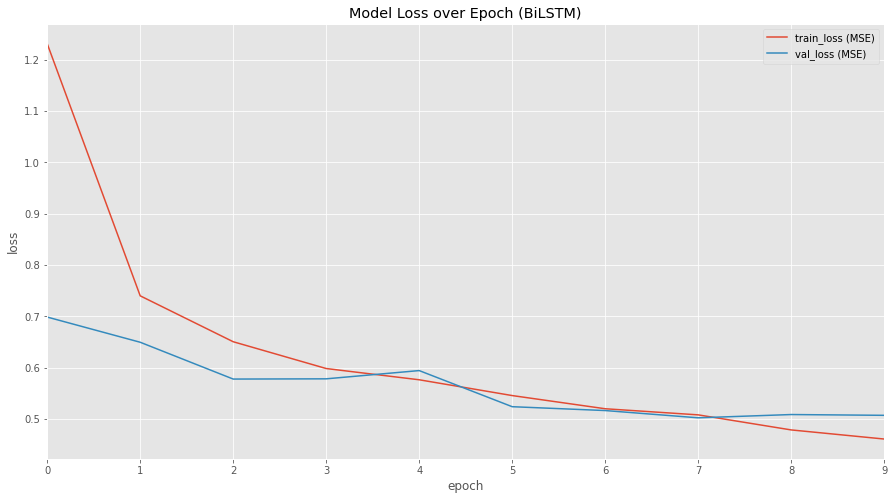

In [ ]:
# Plot the model performance across epochs
plt.style.use('ggplot')
plt.figure(figsize=(15,8))
plt.plot(lstm_mod.history['loss'])
plt.plot(lstm_mod.history['val_loss'])
plt.title('Model Loss over Epoch (BiLSTM)')
plt.ylabel('loss')
plt.legend(['train_loss (MSE)','val_loss (MSE)'], loc = 'upper right')
plt.xlabel('epoch')
plt.xlim(0, 9, 1)
plt.show()

Looking at the model loss plot above, the neural network model fits well to the training data as both the training and validation losses converge and are very close. Note that the hyperparameters and hidden layers of this model have been tuned manually.

In [ ]:
# predict on training, internal test set (that is, validation) and actual test set
y_pred_train = model.predict([X_train_txt, X_train_others])
y_pred_val = model.predict([X_val_txt, X_val_others])
y_pred_test = model.predict([X_test_txt, X_test_others])

# convert to list
y_pred_train = y_pred_train.reshape(y_pred_train.shape[0]).tolist()
y_pred_val = y_pred_val.reshape(y_pred_val.shape[0]).tolist()
y_pred_test = y_pred_test.reshape(y_pred_test.shape[0]).tolist()

# rating correction: round ratings below 1 to 1 and ratings above 5 to 5
y_pred_train_corr = rounding_procedure(y_pred_train)
y_pred_val_corr = rounding_procedure(y_pred_val)
y_pred_tst_corr = rounding_procedure(y_pred_test)

# calculate mse on training and validation
y_train_mse = mean_squared_error(y_train, y_pred_train_corr) 
y_val_mse = mean_squared_error(y_val, y_pred_val_corr)

In [ ]:
# put in dataFrame (will be used to ensemble later)
y_pred_trn_df_lstm = pd.DataFrame(y_pred_train_corr, columns=['prediction_lstm'])
y_pred_val_df_lstm = pd.DataFrame(y_pred_val_corr, columns=['prediction_lstm'])
y_pred_tst_df_lstm = pd.DataFrame(y_pred_tst_corr, columns=['prediction_lstm'])

In [ ]:
print("Result with Bidirectional LSTM (BiLSTM) Model\n")
print("MSE on training set = {:.3f}".format(y_train_mse))
print("MSE on testing set = {:.3f}".format(y_val_mse))

Result with Bidirectional LSTM (BiLSTM) Model

MSE on training set = 0.414
MSE on testing set = 0.497


In [ ]:
lstm_train = y_train_mse.copy()
lstm_test = y_val_mse.copy()

By using a BiLSTM model, the results have improved although not significantly. This model is also fitting very well as the MSE on both training as well as the unseen test data are similar. Next, we will explore the power of ensembling the results from the above models and see if any improvements can be made. 

### **4.4 Stacked Ensembling Approach**
In this approach, we will assume the baseline model (Ridge Regression from section 4.1) and BiLSTM model (section 4.2) as 'base learning models' whose predictions will be used as inputs to a linear regression algorithm which will make the final ratings prediction. 

Stacking models like this allows for each base model to use their individual strengths by feeding their outputs as inputs to a final estimator. 

In [ ]:
# collecting output from baseline and LSTM model together
X_new_trn_all = pd.concat([y_pred_trn_df_baseline, y_pred_trn_df_lstm], axis=1) # train
X_new_val_all = pd.concat([y_pred_val_df_baseline, y_pred_val_df_lstm], axis=1) # validation (internal test set)
X_new_tst_all = pd.concat([y_pred_tst_df_baseline, y_pred_tst_df_lstm], axis=1) # actual test set (kaggle)

X_new_trn_all.head()

,prediction_baseline,prediction_lstm
0,4.960216,5.000000
1,3.187755,2.950125
2,4.156763,4.737684
3,5.000000,4.902352
4,5.000000,4.910620


The above table shows the new features which basically represent the output of baseline and BiLSTM predictions. These will now be used as input features for a Linear Regression model. As regression based model is being used, it is important to standardize the data first.

In [ ]:
# as we will use regularized regression model on this new data, we need to standardize it
sc = StandardScaler()
X_new_trn_all_std = sc.fit_transform(X_new_trn_all)
X_new_val_all_std = sc.transform(X_new_val_all)
X_new_tst_all_std = sc.transform(X_new_tst_all)

In [ ]:
lr = LinearRegression()

# fit linear regression on training data
lr.fit(X_new_trn_all_std, y_train)

# predict on training, validation and actual test data
y_pred_train = lr.predict(X_new_trn_all_std)
y_pred_val = lr.predict(X_new_val_all_std)
y_pred_test = lr.predict(X_new_tst_all_std) 

# rating correction: round ratings below 1 to 1 and ratings above 5 to 5
y_pred_train_corr = rounding_procedure(y_pred_train)
y_pred_val_corr = rounding_procedure(y_pred_val)
y_pred_tst_corr = rounding_procedure(y_pred_test)

# calculate mse on training and validation
y_train_mse = mean_squared_error(y_train, y_pred_train_corr) 
y_val_mse = mean_squared_error(y_val, y_pred_val_corr)

In [ ]:
print("Result with Ensembling\n")
print("MSE on training set = {:.3f}".format(y_train_mse))
print("MSE on testing set = {:.3f}".format(y_val_mse))

Result with Ensembling

MSE on training set = 0.386
MSE on testing set = 0.452


In [ ]:
ensemble_train = y_train_mse.copy()
ensemble_test = y_val_mse.copy()

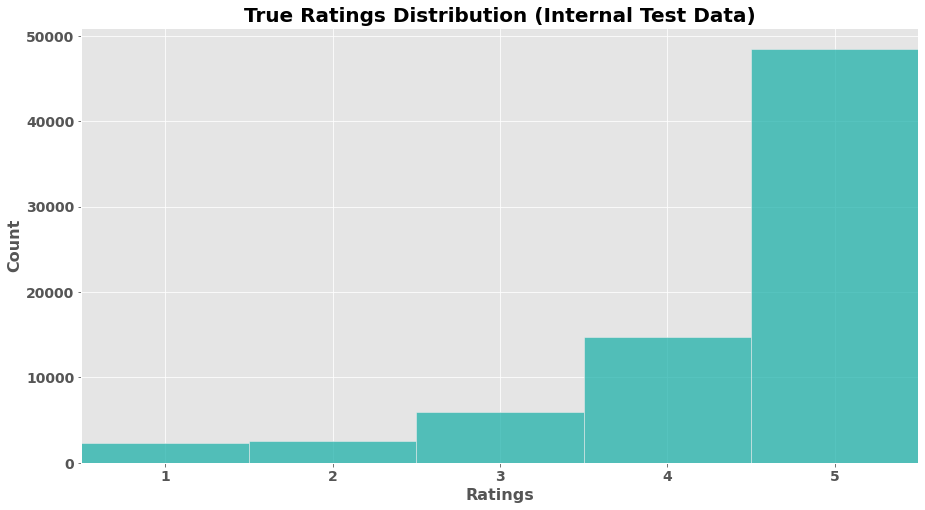

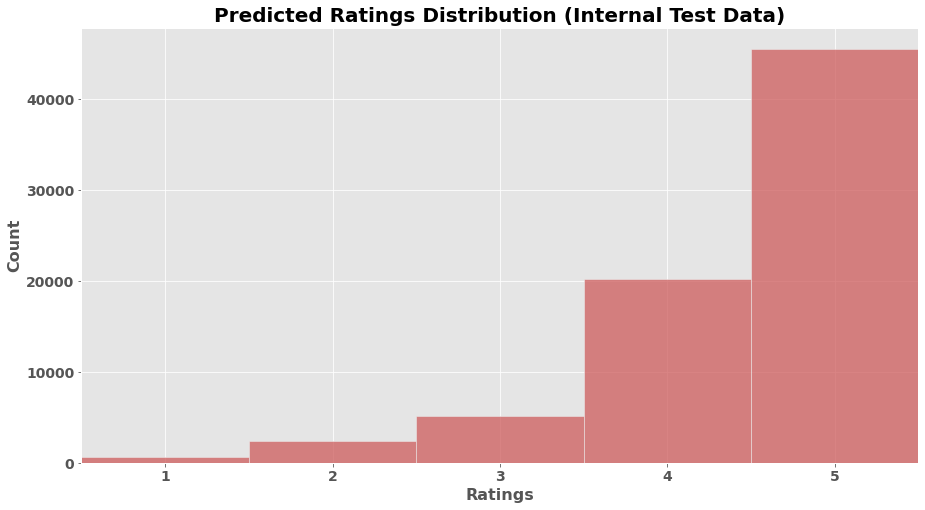

In [ ]:
# plotting actual versus predicted class distribution on test data (internal test data)
y_pred_val_df_ensemble = pd.DataFrame(y_pred_val_corr, columns=['prediction_ensemble'])
y_pred_val_df_ensemble = pd.concat([y_pred_val_df_ensemble, y_val.reset_index()], axis=1)
y_pred_val_df_ensemble.drop(['index'], axis=1, inplace=True)

# true ratings distribution
plt.figure(figsize=(15, 8))
sns.histplot(x='overall', data=y_pred_val_df_ensemble, discrete=True, color='lightseagreen')
plt.title('True Ratings Distribution (Internal Test Data)', fontsize=20, fontweight='bold')
plt.xlabel('Ratings', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=16, fontweight='bold')
plt.xlim(0.5, 5.5, 1)
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.show()

# predicted ratings distribution
plt.figure(figsize=(15, 8))
sns.histplot(x='prediction_ensemble', data=y_pred_val_df_ensemble, discrete=True, color='indianred')
plt.title('Predicted Ratings Distribution (Internal Test Data)', fontsize=20, fontweight='bold')
plt.xlabel('Ratings', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=16, fontweight='bold')
plt.xlim(0.5, 5.5, 1)
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.show()

As seen above, results have vastly improved after ensembling the baseline Ridge Regression model (section 4.1) and BiLSTM model (section 4.2). The model fit is also excellent with MSE on both training and testing data very close. This will be final model that will be adopted to test on actual data (that is, the data submitted on Kaggle).

However, further approaches will be looked at to see if further performance can be achieved.

In [ ]:
##### USING ABOVE MODEL TO WRITE TO ACTUAL TEST FILE FOR KAGGLE #####


### UNCOMMENT BELOW CODE TO WRITE TO READ AND WRITE TO FILE ###

# # put prediction on test set in dataFrame
# y_pred_test_df_final = pd.DataFrame(y_pred_tst_corr, columns=['prediction'])

# # writing to predictions
# rating_pair = pd.read_csv('rating_pairs.csv')
# rating_pair.drop('prediction', axis=1, inplace=True)
# rating_pair = pd.concat([rating_pair, y_pred_test_df_final], axis=1)
# rating_pair.to_csv('rating_pairs_filled.csv', index=False)

### **4.5 Recommendation System Modeling**
Another approach of looking at this task is my implementing a recommendation engine model that will work on the principle of collaborative filtering. This method works by collecting similar informations from many users and the making predictions on that. This implementation will only look at 2 features: reviewerID and itemID since it essentially learns from the user-item pair.

Two algorithms of model-based collaborative filtering will be explored:
- Singular Value Decomposition (SVD)
- K-Nearest Neighbor (KNN)

In [ ]:
from surprise import SVD, SVDpp
from surprise import accuracy as surprise_acc
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans, KNNWithZScore
from surprise.model_selection import GridSearchCV as surprise_GSCV

In [ ]:
# filter out only reviewers who have given more than 5 ratings (these are essentially assumed to be regular reviewers and hence can be trusted)
DF_train_filtered = DF_train_clean[DF_train_clean['reviewerID'].map(DF_train_clean['reviewerID'].value_counts()) > 5]

# filter data into two portions randomly
np.random.seed(0)
rand_sample = np.random.rand(len(DF_train_filtered)) < 0.3
DF_train_part = DF_train_filtered[~rand_sample]
DF_val_part = DF_train_filtered[rand_sample]

In [ ]:
# convert to Dataset format readable by Surprise library
rating = Reader(rating_scale = (1.0, 5.0))
train_data = Dataset.load_from_df(DF_train_part[['reviewerID','itemID','overall']], rating)
val_data = Dataset.load_from_df(DF_val_part[['reviewerID','itemID','overall']], rating)

# Build train and validation sets
train_data_blt = train_data.build_full_trainset()
train_data_for_val_blt = train_data_blt.build_testset()
val_data_blt = val_data.build_full_trainset().build_testset()

#### **4.6(a) SVD**

In [ ]:
# Model-based collaborative learning using SVD
param_grid = {
    'n_epochs': [20, 25], 
    'lr_all': [0.007, 0.009, 0.01],
    'reg_all': [0.4, 0.6]
}

gs = surprise_GSCV(SVDpp, param_grid, measures=["mse"], cv=3)
gs.fit(train_data)

print(gs.best_score["mse"])
print(gs.best_params["mse"])

0.830291379531437
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}


In [ ]:
##### SVD #####
# using best hyperparameters from above
svd_algo = SVDpp(n_epochs = 25, lr_all = 0.01, reg_all = 0.4)         
svd_algo.fit(train_data_blt)
predictions_trn = svd_algo.test(train_data_for_val_blt)
predictions_val = svd_algo.test(val_data_blt)

# calculate mse
y_trn_mse_rec = surprise_acc.mse(predictions_trn, verbose=False)
y_val_mse_rec = surprise_acc.mse(predictions_val, verbose=False)


# print
print("Result with Recommendation System (SVD)\n")
print("MSE on training set = {:.3f}".format(y_trn_mse_rec))
print("MSE on testing set = {:.3f}".format(y_val_mse_rec))

Result with Recommendation System (SVD)

MSE on training set = 0.451
MSE on testing set = 0.808


In [ ]:
svd_train = y_trn_mse_rec.copy()
svd_test = y_val_mse_rec.copy()

Analyzing the results above, it can be seen that model is significantly overfitting. Although the MSE on the training data is low, it is not the case for the testing data. The high MSE on the testing data indicates that the model has overfit. 

One of the reasons for this is that the unseen data would contain unique user-item pairs that were not in the training data. Hence, the model will not know how to predict these.

Next, lets also look at how K-Nearest Neighbors can be applied in terms of a recommendation model.

#### **4.6(b) KNN**

In [ ]:
# Model-based collaborative learning using KNN
sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 5, 7],
    "user_based": [False, True]
}

param_grid = {"sim_options": sim_options, "verbose": [False]}
gs = surprise_GSCV(KNNWithMeans, param_grid, measures=["mse"], cv=3)
gs.fit(train_data)

print(gs.best_score["mse"])
print(gs.best_params["mse"])

In [ ]:
# using best hyperparameters from above
knn_algo = KNNWithMeans(name = 'msd', min_support = 7, user_based = True, verbose=False)         
knn_algo.fit(train_data_blt)
predictions_trn = knn_algo.test(train_data_for_val_blt)
predictions_val = knn_algo.test(val_data_blt)

# calculate mse
y_trn_mse_rec = surprise_acc.mse(predictions_trn, verbose=False)
y_val_mse_rec = surprise_acc.mse(predictions_val, verbose=False)


# print
print("Result with Recommendation System (KNN)\n")
print("MSE on training set = {:.3f}".format(y_trn_mse_rec))
print("MSE on testing set = {:.3f}".format(y_val_mse_rec))

Result with Recommendation System (KNN)

MSE on training set = 0.120
MSE on testing set = 0.968


This model also overfits for the same reason as mentioned above for the SVD model.

In [ ]:
knn_train = y_trn_mse_rec.copy()
knn_test = y_val_mse_rec.copy()

# **5.0  Results and Discussion**

It is a common text preprocessing technique. The idea is to convert the input text into same casing format so that 'text', 'Text' and 'TEXT' are treated the same way.

The comparison for all the models that we implemented is compared in the table below. A few models were great at MSE error in the training set but due to overfitting on the given data testing results were very poor.

In [ ]:
# combining all model MSE's in a table format
model_name = np.array([['Ridge Regression'], ['Bi LSTM'], ['Ensembling'], ['SVD'], ['k-NN'], ['XGB']])

training_mse = np.array([[round(ridge_train, 3)], [round(lstm_train, 3)],
              [round(ensemble_train, 3)], [round(svd_train, 3)],
              [round(knn_train, 3)],[round(xgb_train, 3)]])

test_mse = np.array([[round(ridge_test, 3)], [round(lstm_test, 3)],
              [round(ensemble_test, 3)], [round(svd_test, 3)],
              [round(knn_test, 3)],[round(xgb_test, 3)]]) 
 
results_np = np.concatenate((model_name, training_mse, test_mse), axis=1) 
Results = pd.DataFrame(results_np, columns = ['Model', 'Training MSE', 'Test MSE'])
Results['Training MSE'] = Results['Training MSE'].astype(float)
Results['Test MSE'] = Results['Test MSE'].astype(float)
Results

,Model,Training MSE,Test MSE
0,Ridge Regression,0.492,0.521
1,Bi LSTM,0.414,0.497
2,Ensembling,0.386,0.452
3,SVD,0.451,0.808
4,k-NN,0.120,0.968
5,XGB,0.452,0.555


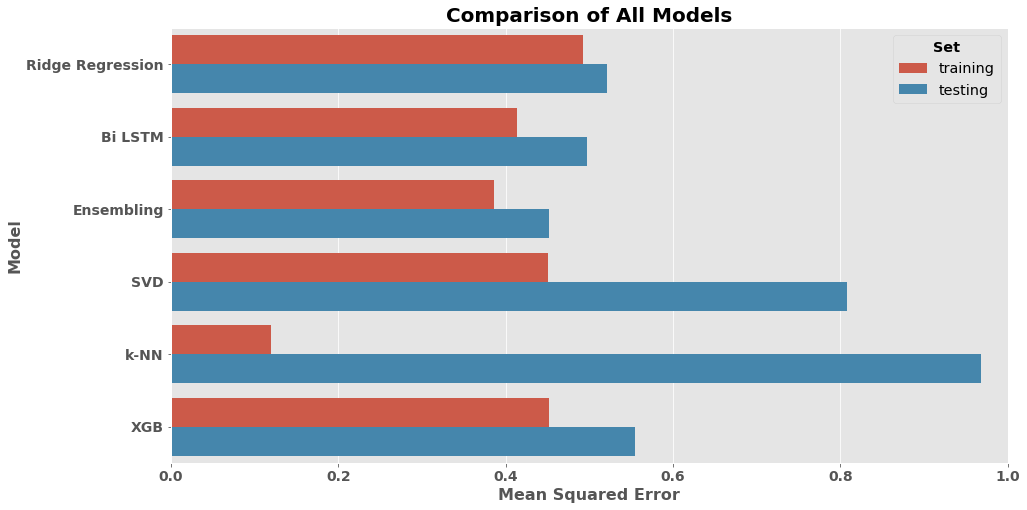

In [ ]:
# making a new dataframe to make side-by-side plots
train_df = pd.DataFrame(np.concatenate((model_name, training_mse), axis=1), columns = ['model', 'mse'])
train_df['set'] = 'training'

test_df = pd.DataFrame(np.concatenate((model_name, test_mse), axis=1), columns = ['model', 'mse'])
test_df['set'] = 'testing'

final_result = pd.concat([train_df, test_df])
final_result['mse'] = final_result['mse'].astype(float)

# plotting all MSE for comparison
plt.figure(figsize=(15, 8))
sns.barplot(y='model', x='mse', data=final_result, hue='set')
plt.xlabel('Mean Squared Error', fontsize=16, fontweight='bold')
plt.ylabel('Model', fontsize=16, fontweight='bold')
plt.title('Comparison of All Models', fontsize=20, fontweight='bold')
plt.xlim(0, 1.0)
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
legend = plt.legend(title='Set', fontsize='x-large')
plt.setp(legend.get_title(),fontsize='x-large', fontweight='bold')
plt.show()

The model with the lowest MSE for the Training and Testing data (giving the best fit) was the Stacked Ensembling. This would be the choice of model deploy in production. The model does have its computational limitations due to the use of deep learning model (Bi-LSTM) as one of the base learners. However, this setback was overcome by using GPU capabilities on Google colab. 


Organisations can use this model to make an informed decision about the taste of music a particular user might prefer based on the available data. Also, this could be used as a recommendation for a better tailored product which a user might buy based on the music preference, for example a person who gives 5 star rating to rock music would be more inclined to buy an electric guitar than others. Moreover, the results from the exploratory analysis also revealed where the music industry as a whole should be focussing their efforts more on Pop music as it has been gaining in popularity since 2006. In conclusion, the model which we have developed is able to predict the rating very accurately with lower MSE and it could be very beneficial to people in the music and e-commerce industry who want to make concrete decisions about their customers.


In [ ]:
########## END OF NOTEBOOK ##########